In [1]:
# takes 25m for 3m hand records.
# perform training experiments on augmented hand records using fastai/pytorch framework.

# next steps:
# acbl_hand_records_chart_experiments.ipynb experiments with the trained data?

# previous steps:
# acbl_hand_records_augment.ipynb created acbl_hand_records_augmented.pkl

# todo:
# save/load trained weights for new inferences.
# move OHE Hands encodings into acbl_hand_records_augmented.pkl?
# how does estimated DD compare to club players? Within 5% of expert?
# think of more features that can make DD predictions more accurate.
# why are worst-case DD pedictions wrong? Wrong because of unusual break in hands?
# Possible to compare DD predictions with normalized hands? i.e. hands which consist of the most common distributions.

In [2]:
import pandas as pd
import pathlib
import pickle
import re
from collections import defaultdict
from IPython.display import display # needed to define display() method in vscode
import mlBridgeLib

In [3]:
# override pandas display options
mlBridgeLib.pd_options_display()

In [4]:
rootPath = pathlib.Path('e:/bridge/data')
acblPath = rootPath.joinpath('acbl')
savedModelsPath = acblPath.joinpath('SavedModels')
# create parent directories in case they don't already exist.
savedModelsPath.mkdir(parents=True, exist_ok=True)

In [5]:
# takes 1m
# load augmented_df
acbl_hand_records_augmented_file = acblPath.joinpath('acbl_hand_records_augmented.pkl')
augmented_df = pd.read_pickle(acbl_hand_records_augmented_file)
augmented_df

,ref,hand_record_id,event_id,Board,EventBoard,Dealer,Vul,board_record_string,Hands,Par,DDmakes,DD_N_C,DD_N_D,DD_N_H,DD_N_S,DD_N_N,DD_E_C,DD_E_D,DD_E_H,DD_E_S,DD_E_N,DD_S_C,DD_S_D,DD_S_H,DD_S_S,DD_S_N,DD_W_C,DD_W_D,DD_W_H,DD_W_S,DD_W_N,Hands_Bin,HB_N,HB_E,HB_S,HB_W,HCP,HCP_N,HCP_N_S,HCP_N_H,HCP_N_D,HCP_N_C,HCP_E,HCP_E_S,HCP_E_H,HCP_E_D,HCP_E_C,HCP_S,HCP_S_S,HCP_S_H,HCP_S_D,HCP_S_C,HCP_W,HCP_W_S,HCP_W_H,HCP_W_D,HCP_W_C,QT,QT_N,QT_N_S,...,CT_NS_H,CT_NS_S,CT_NS_N,CT_EW_C,CT_EW_D,CT_EW_H,CT_EW_S,CT_EW_N,CT_NS_C_Pass,CT_NS_C_Partial,CT_NS_C_Game,CT_NS_C_SSlam,CT_NS_C_GSlam,CT_NS_D_Pass,CT_NS_D_Partial,CT_NS_D_Game,CT_NS_D_SSlam,CT_NS_D_GSlam,CT_NS_H_Pass,CT_NS_H_Partial,CT_NS_H_Game,CT_NS_H_SSlam,CT_NS_H_GSlam,CT_NS_S_Pass,CT_NS_S_Partial,CT_NS_S_Game,CT_NS_S_SSlam,CT_NS_S_GSlam,CT_NS_N_Pass,CT_NS_N_Partial,CT_NS_N_Game,CT_NS_N_SSlam,CT_NS_N_GSlam,CT_EW_C_Pass,CT_EW_C_Partial,CT_EW_C_Game,CT_EW_C_SSlam,CT_EW_C_GSlam,CT_EW_D_Pass,CT_EW_D_Partial,CT_EW_D_Game,CT_EW_D_SSlam,CT_EW_D_GSlam,CT_EW_H_Pass,CT_EW_H_Partial,CT_EW_H_Game,CT_EW_H_SSlam,CT_EW_H_GSlam,CT_EW_S_Pass,CT_EW_S_Partial,CT_EW_S_Game,CT_EW_S_SSlam,CT_EW_S_GSlam,CT_EW_N_Pass,CT_EW_N_Partial,CT_EW_N_Game,CT_EW_N_SSlam,CT_EW_N_GSlam,Vul_NS,Vul_EW
0,"(acbl, 2620401)",77908,100961,09,200217A_09,N,E_W,ST6HK32DJ2CAJ9874SQJ942H765DT874CQSA853HQDKQ963CK52SK7HAJT984DA5CT63,"((T6, K32, J2, AJ9874), (A853, Q, KQ963, K52), (K7, AJT984, A5, T63), (QJ942, 765, T874, Q))","(200, [(4, S, *, EW, -1)])","((10, 4, 10, 4, 8), (2, 9, 3, 9, 2), (10, 4, 10, 4, 8), (2, 9, 3, 9, 2))",10,4,10,4,8,2,9,3,9,2,10,4,10,4,8,2,9,3,9,2,"((0b100010000010000000001100010000000011001011100100, (0b100010000, 0b100000000011, 0b1000000001...",0b100010000010000000001100010000000011001011100100,0b1000001001010001000000000001100100100100100000001001,0b100000100000100111100010010000000010000000100010010,0b11010000101000000011100000001011001000010000000000,"((9, (0, 3, 1, 5)), (14, (4, 2, 5, 3)), (12, (3, 5, 4, 0)), (5, (3, 0, 0, 2)))",9,0,3,1,5,14,4,2,5,3,12,3,5,4,0,5,3,0,0,2,"(6.5, ((1.5, (0, 0.5, 0, 1)), (2.5, (1, 0, 1, 0.5)), (2.5, (0.5, 1, 1, 0)), (0, (0, 0, 0, 0))))",1.50,0.00,...,Game,Pass,Partial,Pass,Partial,Pass,Partial,Pass,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True
1,"(acbl, 2620412)",77908,100961,20,200217A_20,W,Both,ST85HKJDJ43CKJ873SQ32HA643DK96CT94SAJ64HT98DT75CA52SK97HQ752DAQ82CQ6,"((T85, KJ, J43, KJ873), (AJ64, T98, T75, A52), (K97, Q752, AQ82, Q6), (Q32, A643, K96, T94))","(90, [(1, D, , NS, 1), (1, C, , NS, 1), (1, N, , NS, 0)])","((8, 8, 7, 7, 7), (4, 5, 6, 6, 6), (8, 8, 7, 7, 7), (4, 5, 6, 6, 6))",8,8,7,7,7,4,5,6,6,6,8,8,7,7,7,4,5,6,6,6,"((0b101001000010100000000000010000001100101001100010, (0b101001000, 0b101000000000, 0b1000000110...",0b101001000010100000000000010000001100101001100010,0b1001000010100000011100000000001001010001000000001001,0b100010100000001000010100110100010000010010000010000,0b10000000011100000001011001000100100000000110000100,"((9, (0, 4, 1, 4)), (9, (5, 0, 0, 4)), (13, (3, 2, 6, 2)), (9, (2, 4, 3, 0)))",9,0,4,1,4,9,5,0,0,4,13,3,2,6,2,9,2,4,3,0,"(6.5, ((1.0, (0, 0.5, 0, 0.5)), (2, (1, 0, 0, 1)), (2.0, (0.5, 0, 1.5, 0)), (1.5, (0, 1, 0.5, 0))))",1.00,0.00,...,Partial,Partial,Partial,Pass,Pass,Pass,Pass,Pass,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,True
2,"(acbl, 2620411)",77908,100961,19,200217A_19,S,E_W,STH764DAQ92CQJ653SQJ763HKJTD65CAKTSK984H5DT8743C987SA52HAQ9832DKJC42,"((T, 764, AQ92, QJ653), (K984, 5, T8743, 987), (A52, AQ9832, KJ, 42), (QJ763, KJT, 65, AKT))","(140, [(3

In [6]:
# take 7m
# convert Hands to OHE (One Hot Encoding)
tupled_handsl = augmented_df['Hands']
bin_handsl = mlBridgeLib.HandsLToBin(tupled_handsl)
print(len(bin_handsl),bin_handsl[:2])
ohe_handsl = mlBridgeLib.BinLToOHE(bin_handsl)
print(len(ohe_handsl),ohe_handsl[:2])
assert len(ohe_handsl[0]) == 52*4
retupled_handsl = mlBridgeLib.OHEToHandsL(ohe_handsl)
print(len(retupled_handsl),retupled_handsl[:2])
assert len(tupled_handsl) == len(retupled_handsl)
assert tupled_handsl[0] == retupled_handsl[0]
ohe_handsl[:2]

3144755 [('0b100010000010000000001100010000000011001011100100', '0b1000001001010001000000000001100100100100100000001001', '0b100000100000100111100010010000000010000000100010010', '0b11010000101000000011100000001011001000010000000000'), ('0b101001000010100000000000010000001100101001100010', '0b1001000010100000011100000000001001010001000000001001', '0b100010100000001000010100110100010000010010000010000', '0b10000000011100000001011001000100100000000110000100')]
3144755 [(0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,

[(0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,


In [7]:
# takes 2m30s
# create dataframe of OHE hands
ohe_hands_df = pd.DataFrame(ohe_handsl,index=augmented_df.index,columns=[nesw+suit+denom for nesw in mlBridgeLib.NESW for suit in mlBridgeLib.SHDC for denom in mlBridgeLib.ranked_suit],dtype='int8')
ohe_hands_df

,NSA,NSK,NSQ,NSJ,NST,NS9,NS8,NS7,NS6,NS5,NS4,NS3,NS2,NHA,NHK,NHQ,NHJ,NHT,NH9,NH8,NH7,NH6,NH5,NH4,NH3,NH2,NDA,NDK,NDQ,NDJ,NDT,ND9,ND8,ND7,ND6,ND5,ND4,ND3,ND2,NCA,NCK,NCQ,NCJ,NCT,NC9,NC8,NC7,NC6,NC5,NC4,NC3,NC2,ESA,ESK,ESQ,ESJ,EST,ES9,ES8,ES7,...,SC9,SC8,SC7,SC6,SC5,SC4,SC3,SC2,WSA,WSK,WSQ,WSJ,WST,WS9,WS8,WS7,WS6,WS5,WS4,WS3,WS2,WHA,WHK,WHQ,WHJ,WHT,WH9,WH8,WH7,WH6,WH5,WH4,WH3,WH2,WDA,WDK,WDQ,WDJ,WDT,WD9,WD8,WD7,WD6,WD5,WD4,WD3,WD2,WCA,WCK,WCQ,WCJ,WCT,WC9,WC8,WC7,WC6,WC5,WC4,WC3,WC2
0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,1,1,0,...,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,1,1,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,1,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,...,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0
5,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,1,...,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0
6,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0
7,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,...,0,1,1,0,0,0,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0
8,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,1,0
9,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,1,1,0,0,0,1,0,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1


In [8]:
# takes 4m-14m
import fastai.tabular.all

# dependent variable column names
dep_vars = ['DD_N_C', 'DD_N_D', 'DD_N_H', 'DD_N_S', 'DD_N_N']

# continuous valued column names
cont_names = ['Vul_NS', 'Vul_EW']
cont_names += ['SL_N_S', 'SL_N_H', 'SL_N_D', 'SL_N_C']
cont_names += ['HCP_S', 'HCP_E', 'HCP_W'] # HCP_EW
cont_names += ['HCP_N_S', 'HCP_N_H', 'HCP_N_D', 'HCP_N_C']
#cont_names += ['HCP_S_S', 'HCP_S_H', 'HCP_S_D', 'HCP_S_C']
#cont_names += ['HCP_E_S', 'HCP_E_H', 'HCP_E_D', 'HCP_E_C']
#cont_names += ['HCP_W_S', 'HCP_W_H', 'HCP_W_D', 'HCP_W_C']
cont_names += ['QT_N_S', 'QT_N_H', 'QT_N_D', 'QT_N_C']
cont_names += dep_vars

# categorical valued column names. fastai wants ints.
# better?
#cat_names = list(df.select_dtypes(['category']).columns)
#df[cat_names] = df[cat_names].apply(lambda x: x.cat.codes)
cat_names = ['SL_Max_NS', 'SL_Max_EW']

#split = fastai.tabular.all.RandomSplitter(valid_pct=0.2)(fastai.tabular.all.range_of(df))
valid = pd.Series(augmented_df['EventBoard'].between("210801","210901",inclusive='left'),name='Valid',dtype='bool') # note: using augmented_df instead of df for split
#df = pd.concat([augmented_df[cont_names+cat_names],valid,ohe_hands_df],axis='columns')
df = pd.concat([augmented_df[cont_names+cat_names],valid],axis='columns')
display(df.head())

#cont_names += ohe_hands_df.columns.to_list()
for n in cat_names:
    df[n] = df[n].cat.codes
cont_names += cat_names
cat_names = []
print(cont_names, cat_names)

# current fastai/pytorch has a bug where bool is treated as object and thus erroring out.
for n in augmented_df: # only care about bool columns originating from augmented_df, ignoring others.
    if n in df and pd.api.types.is_bool_dtype(df[n]):
        df[n] = df[n].astype('uint8')

# special case catagoricals: catagoricals which are to be made into continuous
#df = df.astype({'Par_Score':'int16'})

# create fastai dataloader
procs = [fastai.tabular.all.Normalize] # fastai.tabular.all.Categorify, fastai.tabular.all.FillMissing, 
y_names = dep_vars
# valid_idx specifies a list of indexes to validation rows.
valid_idx = df[df['Valid']].index
bs = 1024 # fastai results weird out at > 1024 (on 1660ti).
device = 'cuda' # 'cuda' or 'cpu'
# interaction problem between specifying all cont_names, cat_names and valid_idx.
dls = fastai.tabular.all.TabularDataLoaders.from_df(df, proc=procs, cont_names=cont_names, cat_names=cat_names,
    y_names=y_names, valid_idx=valid_idx, bs=bs, device=device, verbose=True) # max is len(df)-len(valid_idx)

# create fastai tabular_learner from dataloader
layers = [8192, 8192, 4096, 4096, 2048, 2048, 1024, 1024, 512, 512, 256, 256, 128, 128, 64, 64, 32, 32, 16, 16]
metrics = fastai.tabular.all.accuracy_multi if len(y_names) else fastai.tabular.all.accuracy
learn = fastai.tabular.all.tabular_learner(dls, layers=layers, metrics=metrics)

# fit data
learn.fit(1)

,Vul_NS,Vul_EW,SL_N_S,SL_N_H,SL_N_D,SL_N_C,HCP_S,HCP_E,HCP_W,HCP_N_S,HCP_N_H,HCP_N_D,HCP_N_C,QT_N_S,QT_N_H,QT_N_D,QT_N_C,DD_N_C,DD_N_D,DD_N_H,DD_N_S,DD_N_N,SL_Max_NS,SL_Max_EW,Valid
0,False,True,2,3,2,6,12,14,5,0,3,1,5,0.00,0.50,0.00,1.00,10,4,10,4,8,SL_NS_H,SL_EW_S,False
1,True,True,3,2,3,5,13,9,9,0,4,1,4,0.00,0.50,0.00,0.50,8,8,7,7,7,SL_NS_D,SL_EW_S,False
2,False,True,1,3,4,5,14,3,14,0,0,6,3,0.00,0.00,1.50,0.00,9,7,9,4,6,SL_NS_H,SL_EW_S,False
3,True,False,1,6,2,4,7,21,7,0,3,1,1,0.00,0.00,0.00,0.00,1,0,10,8,1,SL_NS_H,SL_EW_D,False
4,True,True,1,5,2,5,4,11,16,0,2,0,7,0.00,0.00,0.00,2.00,6,2,6,1,3,SL_NS_H,SL_EW_S,False


['Vul_NS', 'Vul_EW', 'SL_N_S', 'SL_N_H', 'SL_N_D', 'SL_N_C', 'HCP_S', 'HCP_E', 'HCP_W', 'HCP_N_S', 'HCP_N_H', 'HCP_N_D', 'HCP_N_C', 'QT_N_S', 'QT_N_H', 'QT_N_D', 'QT_N_C', 'DD_N_C', 'DD_N_D', 'DD_N_H', 'DD_N_S', 'DD_N_N', 'SL_Max_NS', 'SL_Max_EW'] []
Setting up after_item: Pipeline: 
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: ReadTabBatch


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.061057,0.041738,0.994575,13:27


In [9]:
# show validation data
augmented_df[df['Valid']]['EventBoard']

221        210830A_04
222        210830A_07
223        210830A_10
224        210830A_13
225        210830A_20
226        210830A_23
227        210830A_26
228        210830A_29
229        210830A_03
230        210830A_06
231        210830A_09
232        210830A_16
233        210830A_19
234        210830A_22
235        210830A_25
236        210830A_32
237        210830A_01
238        210830A_08
239        210830A_11
240        210830A_14
241        210830A_17
242        210830A_24
243        210830A_27
244        210830A_30
245        210830A_02
              ...    
3143842    210808A_29
3143843    210808A_03
3143844    210808A_20
3143845    210808A_10
3143846    210808A_06
3143847    210808A_19
3143848    210808A_36
3143849    210808A_04
3143850    210808A_13
3143851    210808A_23
3143852    210808A_05
3143853    210808A_15
3143854    210808A_17
3143855    210808A_01
3143856    210808A_22
3143857    210808A_31
3143858    210808A_28
3143859    210808A_24
3143860    210808A_18
3143861   

In [10]:
# takes 3s
# save model
latest_model_file = savedModelsPath.joinpath('LatestModel')
learn.save(latest_model_file) # defaults to .pth

Path('e:/bridge/data/acbl/SavedModels/LatestModel.pth')

In [11]:
# load model
latest_model_file = savedModelsPath.joinpath('LatestModel')
learn.load(latest_model_file) # defaults to .pth

In [12]:
# takes 15s
# check out predictions
preds, actuals = learn.get_preds()
len(preds), len(actuals), preds, actuals

(179216,
 179216,
 tensor([[ 2.9528,  3.4573, 10.1467,  4.5929,  4.1150],
         [ 1.8264,  3.1401,  2.8079,  4.9332,  1.8446],
         [ 4.7370,  2.3755,  7.1367,  8.3243,  6.2944],
         ...,
         [ 6.0721,  3.1322,  7.1315,  6.2435,  4.1915],
         [ 4.8525,  3.0586,  4.9314,  5.0512,  3.0231],
         [ 5.3267,  0.3840,  5.1461,  1.2362,  2.1377]]),
 tensor([[ 3,  4, 10,  5,  4],
         [ 2,  3,  3,  5,  2],
         [ 5,  2,  7,  8,  6],
         ...,
         [ 6,  3,  7,  6,  4],
         [ 5,  3,  5,  5,  3],
         [ 5,  0,  5,  1,  2]], dtype=torch.int8))

In [13]:
pd.DataFrame(preds).value_counts()

0      1      2      3      4    
5.64   5.13   8.12   8.02   7.09     98
10.84  6.04   9.24   10.98  7.70     98
3.70   5.71   2.69   3.73   3.05     98
8.83   6.07   8.21   5.73   6.96     98
3.78   4.70   6.88   4.47   3.84     98
5.03   3.77   7.99   2.61   5.76     98
8.09   2.07   7.63   7.72   2.26     98
5.81   10.85  8.12   10.84  7.57     98
9.05   3.09   8.00   2.92   4.28     98
12.43  11.99  12.12  4.41   4.69     98
6.07   5.80   5.00   3.81   5.79     98
6.87   7.86   8.21   12.10  7.72     98
4.74   5.99   10.20  9.92   5.70     98
7.73   7.90   9.10   5.75   6.65     98
7.85   6.89   8.19   3.75   5.79     98
9.50   11.93  13.19  12.27  12.86    98
3.02   5.99   3.89   2.89   4.10     98
11.96  10.10  10.97  4.88   7.41     98
8.07   4.00   3.93   5.17   5.61     98
6.74   7.89   8.15   8.96   6.84     98
-0.40  0.87   -0.06  8.04   -0.28    98
8.06   5.71   3.96   6.06   4.95     98
6.01   7.87   3.81   4.69   4.03     98
2.71   1.94   4.03   7.30   2.10     98
7.00  

In [14]:
# takes 10s
# create dataframe of predictions
valid_idx = df[df['Valid']].index
df_preds = pd.concat([df,pd.DataFrame(preds,index=valid_idx,columns=[n+'_pred' for n in y_names])],axis='columns')
for n in y_names:
    df_preds.loc[valid_idx,n+'_var'] = df_preds[n]-df_preds[n+'_pred']
# todo: use SL_Max_NS column as an index into 'DD_N_?', 'DD_N_?_pred', 'DD_N_?_var' to get max for each row
for n in ['SL_Max_NS','SL_Max_EW']:   
    df_preds.loc[valid_idx,n+'_actual'] = df_preds.loc[valid_idx].apply(lambda r: r[['DD_N_C','DD_N_D','DD_N_H','DD_N_S'][int(r[n])]],axis='columns')
    df_preds.loc[valid_idx,n+'_pred'] = df_preds.loc[valid_idx].apply(lambda r: r[['DD_N_C_pred','DD_N_D_pred','DD_N_H_pred','DD_N_S_pred'][int(r[n])]],axis='columns')
    df_preds.loc[valid_idx,n+'_var'] = df_preds.loc[valid_idx,n+'_actual']-df_preds.loc[valid_idx,n+'_pred']
df_preds.sort_index(axis=1, inplace=True)
valid = df_preds.loc[valid_idx]
valid

,DD_N_C,DD_N_C_pred,DD_N_C_var,DD_N_D,DD_N_D_pred,DD_N_D_var,DD_N_H,DD_N_H_pred,DD_N_H_var,DD_N_N,DD_N_N_pred,DD_N_N_var,DD_N_S,DD_N_S_pred,DD_N_S_var,HCP_E,HCP_N_C,HCP_N_D,HCP_N_H,HCP_N_S,HCP_S,HCP_W,QT_N_C,QT_N_D,QT_N_H,QT_N_S,SL_Max_EW,SL_Max_EW_actual,SL_Max_EW_pred,SL_Max_EW_var,SL_Max_NS,SL_Max_NS_actual,SL_Max_NS_pred,SL_Max_NS_var,SL_N_C,SL_N_D,SL_N_H,SL_N_S,Valid,Vul_EW,Vul_NS
221,3,2.95,0.05,4,3.46,0.54,10,10.15,-0.15,4,4.11,-0.11,5,4.59,0.41,10,0,0,4,3,10,13,0.00,0.00,1.00,0.00,0,3.00,2.95,0.05,2,10.00,10.15,-0.15,1,4,4,4,True,1,1
222,2,1.83,0.17,3,3.14,-0.14,3,2.81,0.19,2,1.84,0.16,5,4.93,0.07,11,2,0,4,4,1,18,0.00,0.00,1.00,1.00,0,2.00,1.83,0.17,3,5.00,4.93,0.07,4,1,5,3,True,1,1
223,5,4.74,0.26,2,2.38,-0.38,7,7.14,-0.14,6,6.29,-0.29,8,8.32,-0.32,11,2,2,7,4,5,9,0.00,0.00,2.00,1.00,1,2.00,2.38,-0.38,3,8.00,8.32,-0.32,3,2,3,5,True,1,1
224,5,5.16,-0.16,2,2.22,-0.22,5,5.07,-0.07,3,3.07,-0.07,3,3.06,-0.06,9,3,0,6,1,4,17,0.00,0.00,1.00,0.00,1,2.00,2.22,-0.22,0,5.00,5.16,-0.16,4,2,3,4,True,1,1
225,8,8.02,-0.02,3,3.19,-0.19,5,4.85,0.15,4,4.00,-0.00,6,6.41,-0.41,11,3,4,0,2,8,12,0.00,1.00,0.00,0.00,1,3.00,3.19,-0.19,0,8.00,8.02,-0.02,6,1,3,3,True,1,1
226,5,4.77,0.23,7,7.01,-0.01,7,7.23,-0.23,8,7.73,0.27,10,10.14,-0.14,12,3,7,0,3,11,4,0.50,2.00,0.00,0.50,0,5.00,4.77,0.23,3,10.00,10.14,-0.14,3,3,2,5,True,1,1
227,9,8.97,0.03,7,7.11,-0.11,9,9.20,-0.20,9,8.91,0.09,11,11.10,-0.10,13,7,0,0,4,12,4,1.50,0.00,0.00,1.00,1,7.00,7.11,-0.11,3,11.00,11.10,-0.10,6,0,2,5,True,1,1
228,4,4.08,-0.08,9,8.75,0.25,6,6.07,-0.07,4,4.03,-0.03,6,5.72,0.28,9,5,4,4,3,7,8,1.00,0.50,1.00,0.00,0,4.00,4.08,-0.08,1,9.00,8.75,0.25,3,4,2,4,True,1,1
229,10,9.86,0.14,4,3.83,0.17,8,8.14,-0.14,8,7.76,0.24,4,3.54,0.46,5,5,0,3,1,14,12,1.00,0.00,0.00,0.00,1,4.00,3.83,0.17,0,10.00,9.86,0.14,6,1,3,3,True,1,0
230,6,5.75,0.25,4,4.08,-0.08,6,5.86,0.14,5,4.93,0.07,6,6.13,-0.13,12,4,1,0,1,12,10,1.00,0.00,0.00,0.00,1,4.00,4.08,-0.08,3,6.00,6.13,-0.13,2,3,4,4,True,1,0


In [15]:
# save df_preds
df_preds_file = savedModelsPath.joinpath('LatestModel.pkl')
df_preds.to_pickle(df_preds_file)

In [16]:
df_preds.loc[valid_idx][['DD_N_C','DD_N_D','DD_N_H','DD_N_S','SL_Max_NS','SL_Max_NS_actual','SL_Max_NS_pred','SL_Max_NS_var']]

,DD_N_C,DD_N_D,DD_N_H,DD_N_S,SL_Max_NS,SL_Max_NS_actual,SL_Max_NS_pred,SL_Max_NS_var
221,3,4,10,5,2,10.00,10.15,-0.15
222,2,3,3,5,3,5.00,4.93,0.07
223,5,2,7,8,3,8.00,8.32,-0.32
224,5,2,5,3,0,5.00,5.16,-0.16
225,8,3,5,6,0,8.00,8.02,-0.02
226,5,7,7,10,3,10.00,10.14,-0.14
227,9,7,9,11,3,11.00,11.10,-0.10
228,4,9,6,6,1,9.00,8.75,0.25
229,10,4,8,4,0,10.00,9.86,0.14
230,6,4,6,6,3,6.00,6.13,-0.13


In [17]:
df_preds.dtypes

DD_N_C                 int8
DD_N_C_pred         float32
DD_N_C_var          float32
DD_N_D                 int8
DD_N_D_pred         float32
DD_N_D_var          float32
DD_N_H                 int8
DD_N_H_pred         float32
DD_N_H_var          float32
DD_N_N                 int8
DD_N_N_pred         float32
DD_N_N_var          float32
DD_N_S                 int8
DD_N_S_pred         float32
DD_N_S_var          float32
HCP_E                  int8
HCP_N_C                int8
HCP_N_D                int8
HCP_N_H                int8
HCP_N_S                int8
HCP_S                  int8
HCP_W                  int8
QT_N_C              float32
QT_N_D              float32
QT_N_H              float32
QT_N_S              float32
SL_Max_EW              int8
SL_Max_EW_actual    float64
SL_Max_EW_pred      float64
SL_Max_EW_var       float64
SL_Max_NS              int8
SL_Max_NS_actual    float64
SL_Max_NS_pred      float64
SL_Max_NS_var       float64
SL_N_C                 int8
SL_N_D              

In [18]:
df_preds.loc[valid_idx,['DD_N_C_var','DD_N_D_var','DD_N_H_var','DD_N_S_var','DD_N_N_var','SL_Max_NS_var','SL_Max_NS_actual','SL_Max_NS_pred','SL_Max_NS_var']].describe()

,DD_N_C_var,DD_N_D_var,DD_N_H_var,DD_N_S_var,DD_N_N_var,SL_Max_NS_var,SL_Max_NS_actual,SL_Max_NS_pred,SL_Max_NS_var
count,179216.00,179216.00,179216.00,179216.00,179216.00,179216.00,179216.00,179216.00,179216.00
mean,0.08,0.05,-0.01,0.04,0.09,-0.01,8.34,8.35,-0.01
std,0.18,0.20,0.19,0.22,0.18,0.20,2.15,2.19,0.20
min,-1.06,-1.05,-1.02,-1.26,-1.00,-1.06,0.00,-0.31,-1.06
25%,-0.03,-0.08,-0.14,-0.10,-0.02,-0.13,7.00,6.91,-0.13
50%,0.09,0.04,-0.02,0.04,0.08,-0.01,8.00,8.25,-0.01
75%,0.20,0.16,0.11,0.18,0.20,0.11,10.00,10.01,0.11
max,1.09,1.51,1.31,1.22,1.65,1.51,13.00,13.80,1.51


<AxesSubplot:title={'center':'Frequency of Variance - Actual vs Predicted'}, xlabel='Variance by .1', ylabel='Percent'>

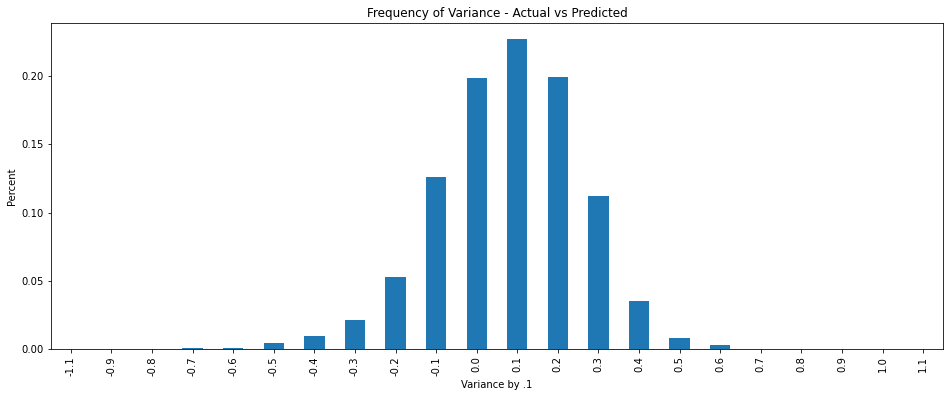

In [19]:
df_preds.loc[valid_idx,'DD_N_C_var'].astype('float').round(1).value_counts(normalize=True).sort_index().plot(kind='bar',xlabel='Variance by .1',ylabel='Percent',title='Frequency of Variance - Actual vs Predicted',figsize=(16,6))

<AxesSubplot:title={'center':'Frequency of Variance - Actual vs Predicted'}, xlabel='Variance by Trick', ylabel='Percent'>

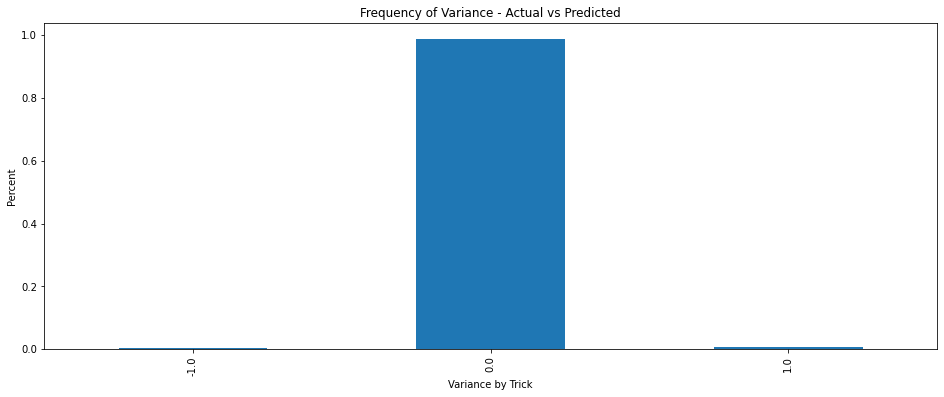

In [20]:
df_preds.loc[valid_idx,'DD_N_C_var'].astype('float').round(0).value_counts(normalize=True).sort_index().plot(kind='bar',xlabel='Variance by Trick',ylabel='Percent',title='Frequency of Variance - Actual vs Predicted',figsize=(16,6))